In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

In [5]:
# Load the dataset
df_ben_ddos = pd.read_csv('df_ben_ddos.csv')
df_ben_ddos

,id.orig_addr,id.orig_port,id.resp_haddr,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes,Category
0,3232235972,48438,2300985238,23,1,5.030600,4,1,60,0,0,0
1,3232235972,33878,1352962162,23,1,3.089012,4,3,180,0,0,0
2,3232235972,55416,1539874379,23,1,3.089276,4,3,180,0,0,0
3,3232235972,47778,2258007740,23,1,5.030600,4,1,60,0,0,0
4,3232235972,46752,1732534418,23,1,3.130498,4,3,180,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2314090,3232235971,59699,2734184663,62336,1,5.030600,0,0,0,0,0,1
2314091,3232235971,32909,2734184663,62336,1,5.030600,0,0,0,0,0,1
2314092,3232235971,25120,2734184663,62336,1,5.030600,0,0,0,0,0,1
2314093,3232235971,30340,2734184663,62336,1,5.030600,0,0,0,0,0,1


In [6]:
# Sampled dataset, it could be either random rows or 10k from beningn and 10k from malicious to balance the trained dataset
#df_sampled = df_ben_ddos.sample(frac=0.01, random_state=42)
df_first = df_ben_ddos[:70000].sample(n=50000, random_state=42)
df_last = df_ben_ddos[80000:].sample(n=50000, random_state=42)
df_sampled = pd.concat([df_first, df_last])
df_sampled

# min_values = []
# max_values = []
# for col in df_sampled:
#
#     min_values.append(min(df_sampled[col]))
#     max_values.append(max(df_sampled[col]))
#
# print(min_values)
# print(max_values)

,id.orig_addr,id.orig_port,id.resp_haddr,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes,Category
46730,3296074089,5151,2022758712,53,2,5.030600,4,1,540,0,0,0
48393,3296074089,61215,820700452,53,2,5.030600,4,1,540,0,0,0
41416,3296074089,60587,1658561341,53,2,5.030600,4,1,540,0,0,0
34506,3232235972,52092,2210836888,23,1,3.119981,4,3,180,0,0,0
43725,3296074089,5566,3818472118,53,2,5.030600,4,1,540,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
301298,3232235972,6627,3512843912,80,1,4.591175,3,2,80,0,0,1
2294362,3232235971,25797,2734184663,62336,1,5.030600,0,0,0,0,0,1
926346,3232235972,20778,3512843912,22,1,95.031517,0,62,3100,0,0,1
626152,3232235972,26001,3512843912,80,1,4.856502,3,4,160,0,0,1


In [7]:
# Separate features and target labels
# X = df_sampled.drop(columns=['Category', 'id.resp_haddr', 'id.resp_pport', 'proto_enum', 'conn_state_string', 'resp_pkts_count', 'resp_bytes'])
X = df_sampled.drop(columns=['Category', 'id.orig_addr', 'id.resp_haddr'])
y = df_sampled['Category']
X

,id.orig_port,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes
46730,5151,53,2,5.030600,4,1,540,0,0
48393,61215,53,2,5.030600,4,1,540,0,0
41416,60587,53,2,5.030600,4,1,540,0,0
34506,52092,23,1,3.119981,4,3,180,0,0
43725,5566,53,2,5.030600,4,1,540,0,0
...,...,...,...,...,...,...,...,...,...
301298,6627,80,1,4.591175,3,2,80,0,0
2294362,25797,62336,1,5.030600,0,0,0,0,0
926346,20778,22,1,95.031517,0,62,3100,0,0
626152,26001,80,1,4.856502,3,4,160,0,0


In [8]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [10]:
# Define the neural network with stronger regularization and dropout
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),  # Stronger L2 regularization
    Dropout(0.5),  # Increased dropout
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output
])

/Users/panagiotis04/Documents/Master Cybersecurity/First Semester/Traffic Monitor Analysis/Test/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [12]:
# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,  # Increase the number of epochs since early stopping is applied
    batch_size=64,
    callbacks=[early_stopping],  # Stop training when validation loss stops improving
    verbose=1
)


Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9248 - loss: 0.5298 - val_accuracy: 0.9952 - val_loss: 0.1040
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9920 - loss: 0.1148 - val_accuracy: 0.9959 - val_loss: 0.0767
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9926 - loss: 0.0978 - val_accuracy: 0.9958 - val_loss: 0.0680
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9935 - loss: 0.0847 - val_accuracy: 0.9966 - val_loss: 0.0594
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9942 - loss: 0.0755 - val_accuracy: 0.9964 - val_loss: 0.0547
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9953 - loss: 0.0667 - val_accuracy: 0.9963 - val_loss: 0.0524
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9952 - loss: 0.0628 - val_accuracy: 0.9962 - val_loss: 0.0506
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9955 - loss: 0

In [14]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - accuracy: 0.9966 - loss: 0.0352
Test Loss: 0.03390650823712349
Test Accuracy: 0.9969499707221985


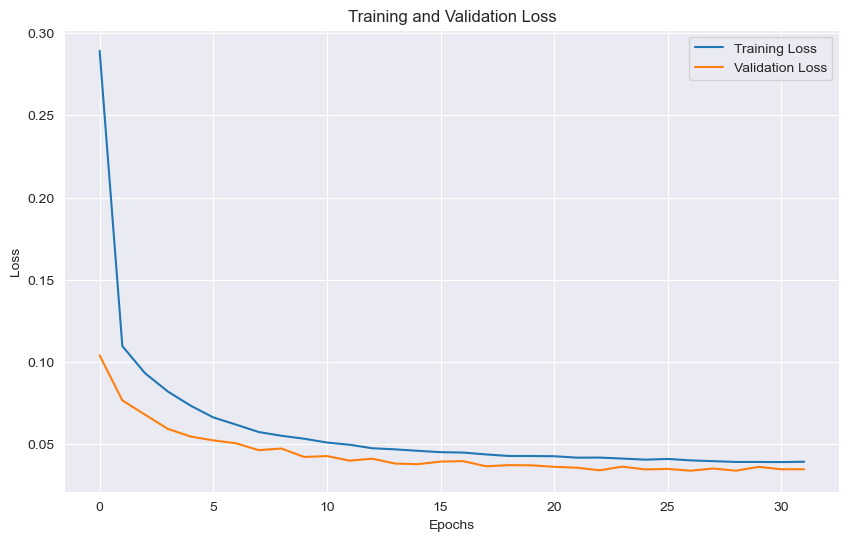

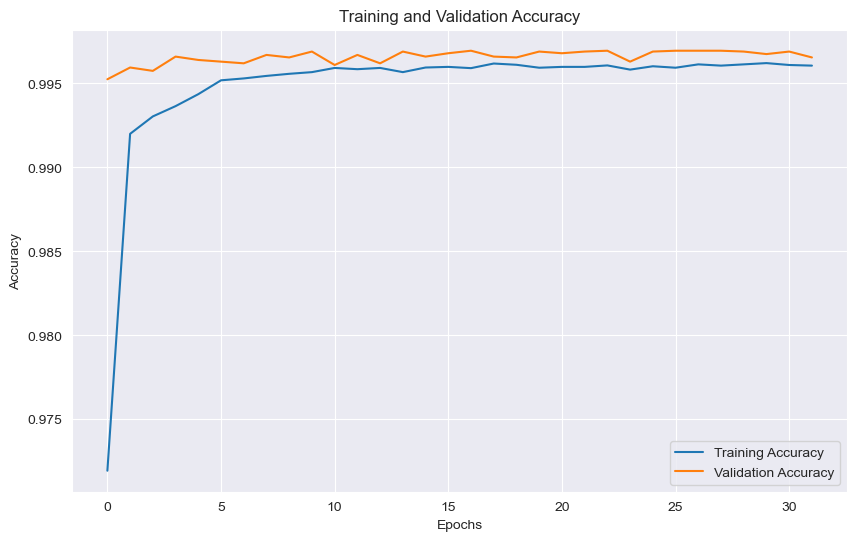

In [15]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Threshold of 0.5 for binary classification

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step


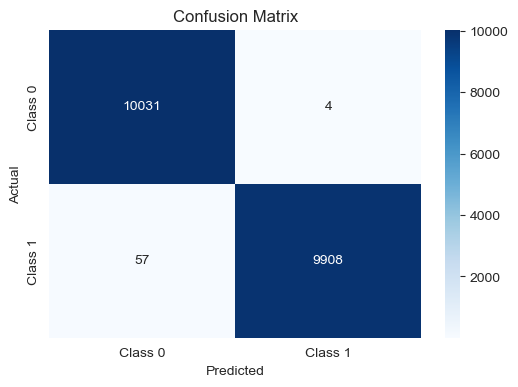

In [17]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [18]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, model.predict(X_test))
print(f"ROC-AUC Score: {roc_auc:.2f}")
model.save('nn.h5')

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.99      1.00      1.00     10035
     Class 1       1.00      0.99      1.00      9965

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


ROC-AUC Score: 1.00


In [19]:
import ipaddress
import tensorflow as tf
from keras import layers as l, models as m
import numpy as np

NOISE_DIM = 100
COLUMNS = 9

# id.orig_addr	id.orig_port	id.resp_haddr	id.resp_pport	proto_enum	duration_interval	conn_state_string	orig_pkts_count	orig_ip_bytes_count	resp_pkts_count	resp_bytes
min_values = []
max_values = []
# X = id.orig_addr	id.orig_port	duration_interval	orig_pkts_count	orig_ip_bytes_count
for col in X:

    min_values.append(min(X[col]))
    max_values.append(max(X[col]))

array1 = np.array(min_values)
array2 = np.array(max_values)
# print(min_values)
# print(max_values)

# Features that will be used in the generator
modifiable_features = ['id.orig_addr', 'id.orig_port', 'duration_interval', 'orig_pkts_count', 'orig_ip_bytes_count']

# Features which values will remain fixed
fixed_features = ['id.resp_haddr', 'id.resp_pport', 'proto_enum', 'conn_state_string', 'resp_pkts_count', 'resp_bytes']
final_features = ['id.orig_addr','id.orig_port','id.resp_haddr','id.resp_pport','proto_enum','duration_interval','conn_state_string','orig_pkts_count','orig_ip_bytes_count','resp_pkts_count','resp_bytes', 'Category']
# Extract the features from the dataset
X_modifiable = X[:5]
X_fixed = X[5:]

def make_generator_model():
    model = m.Sequential([
        l.Input(shape=(NOISE_DIM,)),
        l.Dense(64, activation='relu'),
        l.Dense(32, activation='relu'),
        l.Dense(COLUMNS, activation='tanh')
    ])

    return model


BATCH_SIZE = 256

cross_entropy = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 500

generator = make_generator_model()
discriminator = tf.keras.models.load_model('nn.h5')

@tf.function
def train_step():
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape:
        generated_flows = generator(noise, training=True)
        fake_output = discriminator(generated_flows, training=False)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))



def denormalize_min_max(normalized_data):
    denormalized_data = ((normalized_data + 1) / 2) * (array2 - array1) + array1
    denormalized_data = [round(val) for val in denormalized_data]
    denormalized_data[0] = str(ipaddress.IPv4Address(denormalized_data[0]))
    return denormalized_data

def get_trained_gan():
    # Initialize a list to store the denormalized flows
    denormalized_flows = []

    for epoch in range(EPOCHS):
        train_step()

        seed = tf.random.normal([1, NOISE_DIM])
        flow = generator(seed, training=False)

        # Denormalize the flow
        denormalized_flow = denormalize_min_max(flow[0].numpy())
        # 'id.resp_haddr' this is the most repeated value 52879
        d = str(ipaddress.IPv4Address(round(((52879 + 1) / 2) * (65272 - 0) + 0)))
        # denormalized_flow.insert(2,d)
        # 'id.resp_pport' is the most repeated port
        # denormalized_flow.insert(3,80)
        # 'proto_enum' most repeated
        # denormalized_flow.insert(4,1)
        # 'conn_state_string' most repeated is 3
        # denormalized_flow.insert(6,3)
        # 'resp_pkts_count' mean is 0.003
        # denormalized_flow.insert(9,0)
        # 'resp_bytes' mean is 2.28
        # denormalized_flow.insert(10,2)
        # label is 1
        # denormalized_flow.append(1)
       
        # Append the denormalized flow to the list
        denormalized_flows.append(denormalized_flow)

        predicted = discriminator.predict(flow)
        print(f"Denormalised Flow {denormalized_flow}, {predicted}")

        # Optionally, print in a more readable format
        # formatted_flow = [f"{num:.2f}" for num in denormalized_flow]
        # print(f"Denormalized Flow {formatted_flow}, {predicted}")

    # Convert the list of denormalized flows into a DataFrame
    # df = pd.DataFrame(denormalized_flows, columns=final_features)

    # Export the DataFrame to CSV
    # df.to_csv("denormalized_flows.csv")

    return generator, discriminator

# Train the GAN
generator, discriminator = get_trained_gan()

# Generate adversarial samples
noise = tf.random.normal([len(X_test), NOISE_DIM])
adversarial_samples = generator(noise, training=False)

X


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Denormalised Flow ['0.0.30.112', 7579, 2, 84, 8, 79, 2413, 7, 507], [[0.00161964]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Denormalised Flow ['0.0.47.149', 35897, 2, 89, 8, 71, 1876, 6, 805], [[0.00046088]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Denormalised Flow ['0.0.79.195', 5399, 2, 72, 5, 73, 2840, 5, 723], [[0.8186713]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Denormalised Flow ['0.0.84.177', 22262, 1, 67, 7, 46, 1695, 4, 911], [[0.00136028]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Denormalised Flow ['0.0.92.97', 4799, 2, 67, 8, 86, 1918, 7, 664], [[0.00094333]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Denormalised Flow ['0.0.84.223', 7358, 2, 63, 7, 69, 3053, 4, 969], [[0.01086204]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Denormalised Flow ['0.0.13.21', 26799, 1, 64, 7, 39, 1400, 5, 704], [[0.0006664]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Denormalised Flow ['0.0.60.176', 12071, 1, 70, 8, 73, 789, 8, 505], [[0.00044162]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/

,id.orig_port,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes
46730,5151,53,2,5.030600,4,1,540,0,0
48393,61215,53,2,5.030600,4,1,540,0,0
41416,60587,53,2,5.030600,4,1,540,0,0
34506,52092,23,1,3.119981,4,3,180,0,0
43725,5566,53,2,5.030600,4,1,540,0,0
...,...,...,...,...,...,...,...,...,...
301298,6627,80,1,4.591175,3,2,80,0,0
2294362,25797,62336,1,5.030600,0,0,0,0,0
926346,20778,22,1,95.031517,0,62,3100,0,0
626152,26001,80,1,4.856502,3,4,160,0,0


In [20]:
df_ben_ddos['resp_pkts_count'].median()

0.0

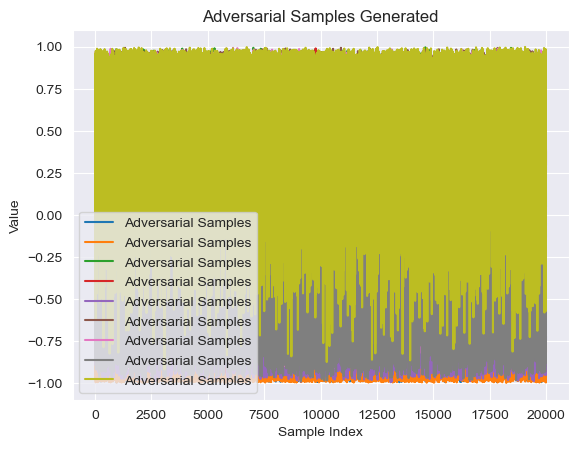

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step
Predictions on adversarial examples (discriminator output): [0.9997462]
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.9967 - loss: 0.0352
Test Loss: 0.03390650823712349
Test Accuracy: 0.9969499707221985
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
Original accuracy: 0.4956
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.9967 - loss: 0.0352
Test Loss: 0.03390650823712349
Test Accuracy: 0.9969499707221985
Adversarial accuracy: 0.9974


,id.orig_port,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes
46730,5151,53,2,5.030600,4,1,540,0,0
48393,61215,53,2,5.030600,4,1,540,0,0
41416,60587,53,2,5.030600,4,1,540,0,0
34506,52092,23,1,3.119981,4,3,180,0,0
43725,5566,53,2,5.030600,4,1,540,0,0
...,...,...,...,...,...,...,...,...,...
301298,6627,80,1,4.591175,3,2,80,0,0
2294362,25797,62336,1,5.030600,0,0,0,0,0
926346,20778,22,1,95.031517,0,62,3100,0,0
626152,26001,80,1,4.856502,3,4,160,0,0


In [21]:
import matplotlib.pyplot as plt

# Assuming adversarial_samples is a 1D array or list
plt.plot(adversarial_samples, label='Adversarial Samples')
plt.title('Adversarial Samples Generated')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


# Evaluate classifier's performance on adversarial samples
predictions_on_adversarial = discriminator.predict(adversarial_samples)
print("Predictions on adversarial examples (discriminator output):", predictions_on_adversarial[0])

# To check detection evasion success:
# If the discriminator is predicting "real" (output near 1) for adversarial examples,
# then the detection evasion is successful.

# You can also compare the classifier's performance on original vs adversarial samples:
# Original test accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

original_predictions = discriminator.predict(X_test)
original_accuracy = (original_predictions >= 0.5).mean()
print(f"Original accuracy: {original_accuracy:.4f}")

test_loss, test_accuracy = discriminator.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Adversarial test accuracy
adversarial_accuracy = (predictions_on_adversarial >= 0.5).mean()
print(f"Adversarial accuracy: {adversarial_accuracy:.4f}")
X

In [37]:
import pandas as pd

# Load the CSV file
csv_file = "netflow_data_1.csv"
data = pd.read_csv(csv_file)  # Skip the first row if it contains metadata
data
# ['id.orig_addr','id.orig_port','id.resp_haddr','id.resp_pport','proto_enum','duration_interval','conn_state_string','orig_pkts_count','orig_ip_bytes_count','resp_pkts_count','resp_bytes', 'Category']
filtered_flows = data[data['da'] == '172.20.10.2']
selected_features = ['sp', 'dp', 'pr', 'td', 'flg', 'ibyt', 'ipkt', 'opkt', 'obyt']
filtered_flows = filtered_flows[selected_features]
filtered_flows['flg'] = filtered_flows['flg'].map(lambda flg: 4 if flg == '......S.' else flg)
filtered_flows['flg'] = filtered_flows['flg'].map(lambda flg: 4 if flg == '........' else flg)
filtered_flows['pr'] = filtered_flows['pr'].map(lambda pr: 1 if pr == 'TCP' else pr)
filtered_flows['pr'] = filtered_flows['pr'].map(lambda pr: 2 if pr == 'UDP' else pr)
filtered_flows = filtered_flows.rename(columns={
    'sp': 'id.orig_port',
    'dp': 'id.resp_pport',
    'pr': 'proto_enum',
    'td': 'duration_interval',
    'flg': 'conn_state_string',
    'ibyt': 'orig_pkts_count',
    'ipkt': 'orig_ip_bytes_count',
    'opkt': 'resp_pkts_count',
    'obyt': 'resp_bytes'
})
for col in filtered_flows.columns:
    if filtered_flows[col].dtype == 'object':  # Check if the column contains strings
        filtered_flows[col] = filtered_flows[col].astype(float)  # Convert to float first

# Now convert all numeric columns to integers
filtered_flows = filtered_flows.astype(int)

model.predict(filtered_flows)
# filtered_flows

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


array([[0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.4976773e-30],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.000000